In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def rescaling_physical(data):
    '''
    rescale the data from N-body UNITS to Physical UNITS
    '''
    G_pym = 4.30091e-3                  # in m^3 * kg^-1 * s^-2
    M_scale =  1.988e30                 # in Kg (solar Mass --> 1.988 * 10^30 Kg)
    L_scale = 3.08567758130573e16       # in m (1 pc --> 3.08567758130573 * 10^16 m)
    T_scale = np.sqrt(L_scale**3 / (G_pym * M_scale))

    data['m'] = data['m'] * M_scale
    data['x'] = data['x'] * L_scale
    data['y'] = data['y'] * L_scale
    data['z'] = data['z'] * L_scale
    data['vx'] = data['vx'] * (L_scale / T_scale)
    data['vy'] = data['vy'] * (L_scale / T_scale)
    data['vz'] = data['vz'] * (L_scale / T_scale)
    
    return(data)

In [3]:
def energy(data, phys=False):
    '''
    add a column with the energy to the dataframe
    '''

    #compute, in order 01 12 20
    N = len(data)
    m = data['m'].values
    x = data['x'].values
    y = data['y'].values
    z = data['z'].values
    vx = data['vx'].values
    vy = data['vy'].values
    vz = data['vz'].values
    
    #mprod
    m_prod = np.zeros(N)
    m_prod[0::3] = m[0::3] * m[1::3]
    m_prod[1::3] = m[1::3] * m[2::3]
    m_prod[2::3] = m[2::3] * m[0::3]
    
    #reduced mass
    mu = np.zeros(N)
    mu[0::3] = m_prod[0::3] / (m[0::3] + m[1::3])
    mu[1::3] = m_prod[1::3] / (m[1::3] + m[2::3])
    mu[2::3] = m_prod[2::3] / (m[2::3] + m[0::3])
    
    #pos_rel
    pos_rel = np.zeros(N)
    pos_rel[0::3] = np.sqrt((x[0::3] - x[1::3])**2 + (y[0::3] - y[1::3])**2 + (z[0::3] - z[1::3])**2)
    pos_rel[1::3] = np.sqrt((x[1::3] - x[2::3])**2 + (y[1::3] - y[2::3])**2 + (z[1::3] - z[2::3])**2)                      
    pos_rel[2::3] = np.sqrt((x[2::3] - x[0::3])**2 + (y[2::3] - y[0::3])**2 + (z[2::3] - z[0::3])**2)
                                                                              
    #v2_rel                                                                         
    v2_rel = np.zeros(N)
    v2_rel[0::3] = (vx[0::3] - vx[1::3])**2 + (vy[0::3] - vy[1::3])**2 + (vz[0::3] - vz[1::3])**2                                      
    v2_rel[1::3] = (vx[1::3] - vx[2::3])**2 + (vy[1::3] - vy[2::3])**2 + (vz[1::3] - vz[2::3])**2
    v2_rel[2::3] = (vx[2::3] - vx[0::3])**2 + (vy[2::3] - vy[0::3])**2 + (vz[2::3] - vz[0::3])**2
             
    # gravitaional constant
    G=1
    if phys:
        G = 4.30091e-3         # in m^3 * kg^-1 * s^-2 # 
    
    
    #binding energy
    BE = np.zeros(N) 
    BE[0::3] = (0.5 * mu[0::3] * v2_rel[0::3]) - (G * m_prod[0::3] / pos_rel[0::3])
    BE[1::3] = (0.5 * mu[1::3] * v2_rel[1::3]) - (G * m_prod[1::3] / pos_rel[1::3])
    BE[2::3] = (0.5 * mu[2::3] * v2_rel[2::3]) - (G * m_prod[2::3] / pos_rel[2::3])
    
    data['BE'] = BE  
    
    return data

In [4]:
def event(data):
    '''
    return new df with only the first(::3) rows and the corresponing event class
    '''
    
    BE = data['BE'].values
    m = data['m'].values
    
    # maps for the event classes
    fly_by = (BE[0::3] <0) & (BE[1::3] >0) & (BE[2::3] >0)
    exchange1 = (BE[0::3] >0) & (BE[1::3] >0) & (BE[2::3] <0) #bynary tra 0-2
    exchange0 = (BE[0::3] >0) & (BE[1::3] <0) & (BE[2::3] >0) #bynary tra 1_2
    ionization = (BE[0::3] >0) & (BE[1::3] >0) & (BE[2::3] >0)
    merge = (m[0::3]==0) | (m[1::3]==0) | (m[2::3]==0)
    
    # new df
    data_event = data[0::3]
    # identify event class
    ### non sono sicuri sia il metodo migliore dati i warnings
    data_event['event'] = 'unclussified'
    data_event['event'][fly_by] = 'fly_by'
    data_event['event'][exchange1] = 'exchange1'
    data_event['event'][exchange0] = 'exchange0'
    data_event['event'][ionization] = 'ionization'
    data_event['event'][merge] = 'merge'

    return data_event

In [5]:
def unhappend(xSC_event, xSC, xSC10):
    '''
    discriminate between flyby and unhappened
    '''

    #map with flyby events
    idx_flyby = xSC_event[xSC_event['event'] == 'fly_by']['simulation'].values
    #back to original df10 to have more info
    xSC10_flyby = xSC10[xSC10.simulation.isin(idx_flyby)]
    xSC_flyby = xSC[xSC.simulation.isin(idx_flyby)]

    xSC10_flyby

    #compute the centre of the mass of the binary

    m = xSC_flyby['m'].values

    x = xSC10_flyby['x'].values
    y = xSC10_flyby['y'].values
    z = xSC10_flyby['z'].values

    #cm10
    x_cm10 = (m[0::3]*x[0::30] + m[1::3]*x[1::30]) / (m[0::3] + m[1::3])
    y_cm10 = (m[0::3]*y[0::30] + m[1::3]*y[1::30]) / (m[0::3] + m[1::3])
    z_cm10 = (m[0::3]*z[0::30] + m[1::3]*z[1::30]) / (m[0::3] + m[1::3])

    dist10 = np.sqrt((x_cm10 - x[2::30])**2 + (y_cm10 - y[2::30])**2 + (z_cm10 - z[2::30])**2)

    #cm
    x_cm = (m[0::3]*x[27::30] + m[1::3]*x[28::30]) / (m[0::3] + m[1::3])
    y_cm = (m[0::3]*y[27::30] + m[1::3]*y[28::30]) / (m[0::3] + m[1::3])
    z_cm = (m[0::3]*z[27::30] + m[1::3]*z[28::30]) / (m[0::3] + m[1::3])

    dist = np.sqrt((x_cm - x[29::30])**2 + (y_cm - y[29::30])**2 + (z_cm - z[29::30])**2)

    #mask
    ok = (dist < dist10)

    xSC_flyby_event = xSC_event[xSC_event.simulation.isin(idx_flyby)]

    xSC_flyby_event['flyby'] = 'false'
    xSC_flyby_event['flyby'][ok] = 'ok'

    return xSC_flyby_event

In [6]:
def tot_masses(xSC_event, xSC, xSC_flyby_event):
    '''
    return concatenate array of all masses of binary system in fly-bies and exchanges
    '''
    
    idx_flyby = xSC_event[xSC_event['event']=='fly_by']['simulation'].values
    xSC_flyby = xSC[xSC.simulation.isin(idx_flyby)]
    idx_flyby_clear = xSC_flyby_event[xSC_flyby_event['flyby']=='ok']['simulation'].values
    xSC_flyby_clear = xSC_flyby[xSC_flyby.simulation.isin(idx_flyby_clear)]
    m1_fb = xSC_flyby_clear['m'][0::3].values
    m2_fb = xSC_flyby_clear['m'][1::3].values

    idx_exchange0 = xSC_event[xSC_event['event']=='exchange0']['simulation'].values
    xSC_exchange0 = xSC[xSC.simulation.isin(idx_exchange0)]
    m1_e0 = xSC_exchange0['m'][2::3].values
    m2_e0 = xSC_exchange0['m'][1::3].values

    idx_exchange1 = xSC_event[xSC_event['event']=='exchange1']['simulation'].values
    xSC_exchange1 = xSC[xSC.simulation.isin(idx_exchange1)]
    m1_e1 = xSC_exchange0['m'][0::3].values
    m2_e1 = xSC_exchange0['m'][2::3].values

    m1 = np.concatenate((m1_fb, m1_e0, m2_e1))
    m2 = np.concatenate((m2_fb, m2_e0, m1_e1))
    
    return m1, m2

# YSC

In [7]:
#import data YSC
names = ['m', 'x', 'y', 'z', 'vx', 'vy', 'vz']
YSC_import = pd.read_csv("YSC_N10000_endsim.dat", sep=",", header=0, names=names)
YSC_import['simulation'] = [(i//3) for i in range(len(YSC_import))]
YSC = YSC_import.copy()

YSC

,m,x,y,z,vx,vy,vz,simulation
0,50.279995,0.113208,0.034386,0.022581,-1.554359,73.003181,95.337515,0
1,42.430295,0.112654,0.034437,0.022792,39.727262,-74.967304,-105.389632,0
2,7.922303,-1.321844,-0.402669,-0.265383,-202.906440,-61.814698,-40.626653,0
3,42.605799,-0.019820,-0.069529,0.122362,241.117960,80.541936,27.483283,1
4,30.012587,-0.019903,-0.069464,0.122363,-349.486512,-139.539435,5.347029,1
...,...,...,...,...,...,...,...,...
29995,3.098252,-5.563291,7.298985,-13.133733,-830.689000,1089.850835,-1961.070821,9998
29996,63.138950,0.160927,-0.211130,0.380030,128.713258,-73.831570,41.613869,9998
29997,39.670667,0.069257,0.330360,0.923332,371.029933,-362.176070,-76.691799,9999
29998,32.617436,0.069270,0.330361,0.923332,-428.369489,549.682340,398.450981,9999


In [8]:
YSC_phys = rescaling_physical(YSC)
YSC_phys

,m,x,y,z,vx,vy,vz,simulation
0,9.995663e+31,3.493244e+15,1.061028e+15,6.967651e+14,-8.182091e+05,3.842863e+07,5.018535e+07,0
1,8.435143e+31,3.476133e+15,1.062604e+15,7.033028e+14,2.091230e+07,-3.946254e+07,-5.547675e+07,0
2,1.574954e+31,-4.078784e+16,-1.242506e+16,-8.188868e+15,-1.068093e+08,-3.253905e+07,-2.138573e+07,0
3,8.470033e+31,-6.115676e+14,-2.145452e+15,3.775702e+15,1.269237e+08,4.239700e+07,1.446711e+07,1
4,5.966502e+31,-6.141322e+14,-2.143431e+15,3.775722e+15,-1.839685e+08,-7.345309e+07,2.814658e+06,1
...,...,...,...,...,...,...,...,...
29995,6.159324e+30,-1.716652e+17,2.252231e+17,-4.052647e+17,-4.372719e+08,5.736938e+08,-1.032301e+09,9998
29996,1.255202e+32,4.965690e+15,-6.514803e+15,1.172651e+16,6.775422e+07,-3.886469e+07,2.190540e+07,9998
29997,7.886529e+31,2.137033e+15,1.019385e+16,2.849105e+16,1.953089e+08,-1.906483e+08,-4.037030e+07,9999
29998,6.484346e+31,2.137444e+15,1.019387e+16,2.849104e+16,-2.254923e+08,2.893509e+08,2.097433e+08,9999


In [9]:
YSC_energy = energy(YSC_phys, phys=True)
YSC_energy

,m,x,y,z,vx,vy,vz,simulation,BE
0,9.995663e+31,3.493244e+15,1.061028e+15,6.967651e+14,-8.182091e+05,3.842863e+07,5.018535e+07,0,-1.567506e+48
1,8.435143e+31,3.476133e+15,1.062604e+15,7.033028e+14,2.091230e+07,-3.946254e+07,-5.547675e+07,0,1.161571e+47
2,1.574954e+31,-4.078784e+16,-1.242506e+16,-8.188868e+15,-1.068093e+08,-3.253905e+07,-2.138573e+07,0,1.453900e+47
3,8.470033e+31,-6.115676e+14,-2.145452e+15,3.775702e+15,1.269237e+08,4.239700e+07,1.446711e+07,1,-4.728382e+48
4,5.966502e+31,-6.141322e+14,-2.143431e+15,3.775722e+15,-1.839685e+08,-7.345309e+07,2.814658e+06,1,3.799008e+47
...,...,...,...,...,...,...,...,...,...
29995,6.159324e+30,-1.716652e+17,2.252231e+17,-4.052647e+17,-4.372719e+08,5.736938e+08,-1.032301e+09,9998,5.112742e+48
29996,1.255202e+32,4.965690e+15,-6.514803e+15,1.172651e+16,6.775422e+07,-3.886469e+07,2.190540e+07,9998,-6.274564e+48
29997,7.886529e+31,2.137033e+15,1.019385e+16,2.849105e+16,1.953089e+08,-1.906483e+08,-4.037030e+07,9999,-4.511801e+49
29998,6.484346e+31,2.137444e+15,1.019387e+16,2.849104e+16,-2.254923e+08,2.893509e+08,2.097433e+08,9999,6.948547e+48


In [10]:
YSC_event = event(YSC_energy)
YSC_event

<ipython-input-4-990b5875d1a1>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_event['event'] = 'unclussified'
<ipython-input-4-990b5875d1a1>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_event['event'][fly_by] = 'fly_by'
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_d

,m,x,y,z,vx,vy,vz,simulation,BE,event
0,9.995663e+31,3.493244e+15,1.061028e+15,6.967651e+14,-8.182091e+05,3.842863e+07,5.018535e+07,0,-1.567506e+48,fly_by
3,8.470033e+31,-6.115676e+14,-2.145452e+15,3.775702e+15,1.269237e+08,4.239700e+07,1.446711e+07,1,-4.728382e+48,fly_by
6,7.438752e+31,3.484184e+14,1.854050e+15,2.940506e+15,6.395293e+06,9.353303e+05,-2.059155e+06,2,-1.360450e+46,fly_by
9,1.385083e+32,-5.497515e+15,-5.088576e+15,2.994602e+15,6.746996e+07,2.520334e+07,-6.163611e+06,3,-8.477184e+48,fly_by
12,1.127816e+32,7.119860e+15,-3.088062e+15,-2.678559e+15,-3.821588e+08,-1.594987e+08,-4.120214e+07,4,-3.185856e+48,fly_by
...,...,...,...,...,...,...,...,...,...,...
29985,5.279679e+31,-9.858336e+15,-2.192626e+16,2.672254e+14,3.892294e+07,-1.070873e+08,5.883044e+07,9995,2.223681e+48,exchange1
29988,9.781779e+31,-1.524748e+16,-8.046017e+15,-1.785259e+15,-1.480240e+08,-1.957547e+07,-5.367927e+06,9996,-2.056932e+49,fly_by
29991,1.473872e+32,4.646662e+15,4.989251e+15,9.167022e+15,-7.903314e+07,-1.512724e+08,2.749785e+07,9997,-4.494624e+48,fly_by
29994,8.733879e+31,4.969695e+15,-6.520387e+15,1.172723e+16,-6.653660e+07,1.539681e+07,4.131848e+07,9998,4.608027e+48,exchange1


In [11]:
#check the events
YSC_event[['simulation','event']].groupby('event').count()

,simulation
event,
exchange0,443
exchange1,1678
fly_by,7617
ionization,63
merge,11
unclussified,188


### discriminate fly-bies from unhappend

In [12]:
#import data YSC10
names = ['m', 'x', 'y', 'z', 'vx', 'vy', 'vz']
YSC_import10 = pd.read_csv("YSC_N10000_last10_from_end.dat", sep=",", header=0, names=names)
YSC_import10['simulation'] = [(i//30) for i in range(len(YSC_import10))]
YSC10 = YSC_import10.copy()

YSC10

,m,x,y,z,vx,vy,vz,simulation
0,50.279995,0.113208,0.034386,0.022581,-1.554359,73.003181,95.337515,0
1,42.430295,0.112654,0.034437,0.022792,39.727262,-74.967304,-105.389632,0
2,7.922303,-1.321844,-0.402669,-0.265383,-202.906440,-61.814698,-40.626653,0
3,50.279995,0.112953,0.034264,0.022483,168.122092,6.734108,-34.460265,0
4,42.430295,0.112702,0.034504,0.022857,-161.339668,3.561711,48.421040,0
...,...,...,...,...,...,...,...,...
299995,32.617436,0.068714,0.327718,0.915943,-1099.252384,513.215024,411.100627,9999
299996,7.494764,-0.662701,-3.160876,-8.834402,-99.628316,-475.193393,-1328.131900,9999
299997,39.670667,0.068638,0.327385,0.915018,2316.053649,485.923064,244.154154,9999
299998,32.617436,0.068640,0.327388,0.915020,-2793.987341,-481.810711,8.224944,9999


In [13]:
YSC10_phys = rescaling_physical(YSC10)
YSC10_phys

,m,x,y,z,vx,vy,vz,simulation
0,9.995663e+31,3.493244e+15,1.061028e+15,6.967651e+14,-8.182091e+05,3.842863e+07,5.018535e+07,0
1,8.435143e+31,3.476133e+15,1.062604e+15,7.033028e+14,2.091230e+07,-3.946254e+07,-5.547675e+07,0
2,1.574954e+31,-4.078784e+16,-1.242506e+16,-8.188868e+15,-1.068093e+08,-3.253905e+07,-2.138573e+07,0
3,9.995663e+31,3.485376e+15,1.057263e+15,6.937488e+14,8.849890e+07,3.544812e+06,-1.813977e+07,0
4,8.435143e+31,3.477615e+15,1.064676e+15,7.053070e+14,-8.492866e+07,1.874873e+06,2.548867e+07,0
...,...,...,...,...,...,...,...,...
299995,6.484346e+31,2.120282e+15,1.011232e+16,2.826304e+16,-5.786427e+08,2.701547e+08,2.164020e+08,9999
299996,1.489959e+31,-2.044881e+16,-9.753444e+16,-2.726011e+17,-5.244401e+07,-2.501402e+08,-6.991241e+08,9999
299997,7.886529e+31,2.117943e+15,1.010204e+16,2.823451e+16,1.219163e+09,2.557883e+08,1.285219e+08,9999
299998,6.484346e+31,2.118016e+15,1.010213e+16,2.823456e+16,-1.470746e+09,-2.536235e+08,4.329583e+06,9999


In [14]:
YSC_flyby_event = unhappend(YSC_event, YSC_phys, YSC10_phys)
YSC_flyby_event

<ipython-input-5-990038b50003>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xSC_flyby_event['flyby'] = 'false'
<ipython-input-5-990038b50003>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xSC_flyby_event['flyby'][ok] = 'ok'
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,m,x,y,z,vx,vy,vz,simulation,BE,event,flyby
0,9.995663e+31,3.493244e+15,1.061028e+15,6.967651e+14,-8.182091e+05,3.842863e+07,5.018535e+07,0,-1.567506e+48,fly_by,ok
3,8.470033e+31,-6.115676e+14,-2.145452e+15,3.775702e+15,1.269237e+08,4.239700e+07,1.446711e+07,1,-4.728382e+48,fly_by,ok
6,7.438752e+31,3.484184e+14,1.854050e+15,2.940506e+15,6.395293e+06,9.353303e+05,-2.059155e+06,2,-1.360450e+46,fly_by,false
9,1.385083e+32,-5.497515e+15,-5.088576e+15,2.994602e+15,6.746996e+07,2.520334e+07,-6.163611e+06,3,-8.477184e+48,fly_by,ok
12,1.127816e+32,7.119860e+15,-3.088062e+15,-2.678559e+15,-3.821588e+08,-1.594987e+08,-4.120214e+07,4,-3.185856e+48,fly_by,ok
...,...,...,...,...,...,...,...,...,...,...,...
29976,6.006614e+31,3.001354e+14,-9.534466e+14,-2.502064e+15,1.158078e+07,1.262088e+07,-1.151217e+07,9992,-2.413108e+47,fly_by,ok
29982,7.981648e+31,-3.487804e+15,-1.288624e+16,3.424570e+15,1.149023e+07,-7.775980e+07,4.070138e+07,9994,-1.948060e+48,fly_by,ok
29988,9.781779e+31,-1.524748e+16,-8.046017e+15,-1.785259e+15,-1.480240e+08,-1.957547e+07,-5.367927e+06,9996,-2.056932e+49,fly_by,ok
29991,1.473872e+32,4.646662e+15,4.989251e+15,9.167022e+15,-7.903314e+07,-1.512724e+08,2.749785e+07,9997,-4.494624e+48,fly_by,ok


In [15]:
#check the events
YSC_flyby_event[['simulation','flyby']].groupby('flyby').count()

,simulation
flyby,
false,389
ok,7228


# NSC

In [16]:
#import data NSC
names = ['m', 'x', 'y', 'z', 'vx', 'vy', 'vz']
NSC_import = pd.read_csv("NSC_N10000_endsim.dat", sep=",", header=0, names=names)
NSC_import['simulation'] = [(i//3) for i in range(len(NSC_import))]
NSC = NSC_import.copy()

NSC

,m,x,y,z,vx,vy,vz,simulation
0,39.689111,1.925802,0.350002,0.968372,1388.557614,3488.776785,508.139712,0
1,26.458487,1.925801,0.350003,0.968372,-1365.137573,-5102.896640,-401.311300,0
2,5.531187,-23.030705,-4.185689,-11.580781,-3433.465959,-624.011507,-1726.487191,0
3,40.231075,0.243291,1.429614,1.285392,54.994388,247.569907,193.816131,1
4,39.334465,0.240934,1.430763,1.285734,17.143140,180.294609,191.428339,1
...,...,...,...,...,...,...,...,...
29995,26.665704,-0.394099,-0.925569,0.727975,-94.481573,57.342166,-27.623747,9998
29996,20.899618,1.151319,2.703387,-2.126038,171.982950,403.838089,-317.588862,9998
29997,35.115653,0.082301,0.469057,0.113693,215.911607,-68.121620,10.964345,9999
29998,28.498771,0.082259,0.469373,0.113706,-238.441375,241.305907,24.625440,9999


In [17]:
NSC_phys = rescaling_physical(NSC)
NSC_phys

,m,x,y,z,vx,vy,vz,simulation
0,7.890195e+31,5.942404e+16,1.079995e+16,2.988083e+16,7.309320e+08,1.836480e+09,2.674830e+08,0
1,5.259947e+31,5.942400e+16,1.079995e+16,2.988083e+16,-7.186038e+08,-2.686148e+09,-2.112489e+08,0
2,1.099600e+31,-7.106533e+17,-1.291569e+17,-3.573456e+17,-1.807365e+09,-3.284776e+08,-9.088170e+08,0
3,7.997938e+31,7.507173e+15,4.411329e+16,3.966306e+16,2.894886e+07,1.303200e+08,1.020242e+08,1
4,7.819692e+31,7.434450e+15,4.414874e+16,3.967359e+16,9.024091e+06,9.490647e+07,1.007672e+08,1
...,...,...,...,...,...,...,...,...
29995,5.301142e+31,-1.216063e+16,-2.856009e+16,2.246296e+16,-4.973478e+07,3.018472e+07,-1.454105e+07,9998
29996,4.154844e+31,3.552600e+16,8.341780e+16,-6.560269e+16,9.053124e+07,2.125790e+08,-1.671777e+08,9998
29997,6.980992e+31,2.539547e+15,1.447360e+16,3.508192e+15,1.136551e+08,-3.585899e+07,5.771594e+06,9999
29998,5.665556e+31,2.538234e+15,1.448333e+16,3.508586e+15,-1.255147e+08,1.270226e+08,1.296275e+07,9999


In [18]:
NSC_energy = energy(NSC_phys, phys=True)
NSC_energy

,m,x,y,z,vx,vy,vz,simulation,BE
0,7.890195e+31,5.942404e+16,1.079995e+16,2.988083e+16,7.309320e+08,1.836480e+09,2.674830e+08,0,-1.443213e+50
1,5.259947e+31,5.942400e+16,1.079995e+16,2.988083e+16,-7.186038e+08,-2.686148e+09,-2.112489e+08,0,3.288023e+49
2,1.099600e+31,-7.106533e+17,-1.291569e+17,-3.573456e+17,-1.807365e+09,-3.284776e+08,-9.088170e+08,0,6.038479e+49
3,7.997938e+31,7.507173e+15,4.411329e+16,3.966306e+16,2.894886e+07,1.303200e+08,1.020242e+08,1,-2.970139e+47
4,7.819692e+31,7.434450e+15,4.414874e+16,3.967359e+16,9.024091e+06,9.490647e+07,1.007672e+08,1,1.019760e+49
...,...,...,...,...,...,...,...,...,...
29995,5.301142e+31,-1.216063e+16,-2.856009e+16,2.246296e+16,-4.973478e+07,3.018472e+07,-1.454105e+07,9998,8.878517e+47
29996,4.154844e+31,3.552600e+16,8.341780e+16,-6.560269e+16,9.053124e+07,2.125790e+08,-1.671777e+08,9998,2.884724e+48
29997,6.980992e+31,2.539547e+15,1.447360e+16,3.508192e+15,1.136551e+08,-3.585899e+07,5.771594e+06,9999,-4.210849e+47
29998,5.665556e+31,2.538234e+15,1.448333e+16,3.508586e+15,-1.255147e+08,1.270226e+08,1.296275e+07,9999,1.787127e+48


In [19]:
NSC_event = event(NSC_energy)
NSC_event

<ipython-input-4-990b5875d1a1>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_event['event'] = 'unclussified'
<ipython-input-4-990b5875d1a1>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_event['event'][fly_by] = 'fly_by'
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_d

,m,x,y,z,vx,vy,vz,simulation,BE,event
0,7.890195e+31,5.942404e+16,1.079995e+16,2.988083e+16,7.309320e+08,1.836480e+09,2.674830e+08,0,-1.443213e+50,fly_by
3,7.997938e+31,7.507173e+15,4.411329e+16,3.966306e+16,2.894886e+07,1.303200e+08,1.020242e+08,1,-2.970139e+47,fly_by
6,1.133926e+32,-2.160735e+16,-2.355496e+16,-2.281402e+16,-1.767717e+08,-6.417639e+07,-2.557021e+07,2,-3.623863e+48,fly_by
9,8.265942e+31,6.947565e+15,-4.621108e+16,-7.447568e+16,3.153776e+08,9.450330e+07,1.788807e+08,3,-2.801992e+49,fly_by
12,4.989323e+31,-6.868574e+16,1.102749e+16,-5.128862e+16,-1.800128e+08,9.725159e+07,-7.321954e+07,4,-1.131312e+48,fly_by
...,...,...,...,...,...,...,...,...,...,...
29985,9.768942e+31,2.598234e+16,2.316585e+15,6.284092e+15,-8.487668e+07,7.278035e+07,1.960410e+07,9995,-1.736197e+49,fly_by
29988,1.163967e+32,-1.632259e+16,6.776702e+14,3.202543e+15,-4.029223e+07,-1.292470e+08,-9.758081e+07,9996,-1.596654e+50,fly_by
29991,1.809707e+32,7.176699e+15,3.115295e+15,-9.620820e+15,4.770766e+06,8.663704e+06,-2.554496e+07,9997,-6.797716e+47,fly_by
29994,6.834522e+31,-1.216468e+16,-2.855897e+16,2.245799e+16,-1.645939e+07,-1.526436e+08,1.129094e+08,9998,-1.637405e+48,fly_by


In [20]:
#check the events
NSC_event[['simulation','event']].groupby('event').count()

,simulation
event,
exchange0,313
exchange1,727
fly_by,7928
ionization,1009
merge,22
unclussified,1


### discriminate fly-byes from unhappend

In [21]:
#import data NSC10
names = ['m', 'x', 'y', 'z', 'vx', 'vy', 'vz']
NSC_import10 = pd.read_csv("NSC_N10000_last10_from_end.dat", sep=",", header=0, names=names)
NSC_import10['simulation'] = [(i//30) for i in range(len(NSC_import10))]
NSC10 = NSC_import10.copy()

NSC10

,m,x,y,z,vx,vy,vz,simulation
0,39.689111,1.925802,0.350002,0.968372,1388.557614,3488.776785,508.139712,0
1,26.458487,1.925801,0.350003,0.968372,-1365.137573,-5102.896640,-401.311300,0
2,5.531187,-23.030705,-4.185689,-11.580781,-3433.465959,-624.011507,-1726.487191,0
3,39.689111,1.923875,0.349652,0.967403,1503.361920,-1595.893660,-74.758195,0
4,26.458487,1.923877,0.349653,0.967403,-1537.350023,2524.374309,473.065972,0
...,...,...,...,...,...,...,...,...
299995,28.498771,0.081633,0.465288,0.112777,296.812645,308.045538,25.824451,9999
299996,4.276117,-1.214212,-6.923836,-1.677817,-183.949852,-1048.798890,-254.159315,9999
299997,35.115653,0.082049,0.464879,0.112663,25.687150,119.699532,19.020444,9999
299998,28.498771,0.080903,0.465020,0.112672,-4.050348,9.876199,14.698867,9999


In [22]:
NSC10_phys = rescaling_physical(NSC10)
NSC10_phys

,m,x,y,z,vx,vy,vz,simulation
0,7.890195e+31,5.942404e+16,1.079995e+16,2.988083e+16,7.309320e+08,1.836480e+09,2.674830e+08,0
1,5.259947e+31,5.942400e+16,1.079995e+16,2.988083e+16,-7.186038e+08,-2.686148e+09,-2.112489e+08,0
2,1.099600e+31,-7.106533e+17,-1.291569e+17,-3.573456e+17,-1.807365e+09,-3.284776e+08,-9.088170e+08,0
3,7.890195e+31,5.936457e+16,1.078915e+16,2.985095e+16,7.913646e+08,-8.400730e+08,-3.935246e+07,0
4,5.259947e+31,5.936464e+16,1.078916e+16,2.985095e+16,-8.092559e+08,1.328822e+09,2.490203e+08,0
...,...,...,...,...,...,...,...,...
299995,5.665556e+31,2.518934e+15,1.435729e+16,3.479920e+15,1.562412e+08,1.621541e+08,1.359390e+07,9999
299996,8.500921e+30,-3.746668e+16,-2.136473e+17,-5.177202e+16,-9.683058e+07,-5.520842e+08,-1.337886e+08,9999
299997,6.980992e+31,2.531773e+15,1.434468e+16,3.476421e+15,1.352163e+07,6.300943e+07,1.001230e+07,9999
299998,5.665556e+31,2.496397e+15,1.434902e+16,3.476692e+15,-2.132090e+06,5.198798e+06,7.737434e+06,9999


In [23]:
NSC_flyby_event = unhappend(NSC_event, NSC_phys, NSC10_phys)
NSC_flyby_event

<ipython-input-5-990038b50003>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xSC_flyby_event['flyby'] = 'false'
<ipython-input-5-990038b50003>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xSC_flyby_event['flyby'][ok] = 'ok'
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,m,x,y,z,vx,vy,vz,simulation,BE,event,flyby
0,7.890195e+31,5.942404e+16,1.079995e+16,2.988083e+16,7.309320e+08,1.836480e+09,2.674830e+08,0,-1.443213e+50,fly_by,ok
3,7.997938e+31,7.507173e+15,4.411329e+16,3.966306e+16,2.894886e+07,1.303200e+08,1.020242e+08,1,-2.970139e+47,fly_by,ok
6,1.133926e+32,-2.160735e+16,-2.355496e+16,-2.281402e+16,-1.767717e+08,-6.417639e+07,-2.557021e+07,2,-3.623863e+48,fly_by,ok
9,8.265942e+31,6.947565e+15,-4.621108e+16,-7.447568e+16,3.153776e+08,9.450330e+07,1.788807e+08,3,-2.801992e+49,fly_by,ok
12,4.989323e+31,-6.868574e+16,1.102749e+16,-5.128862e+16,-1.800128e+08,9.725159e+07,-7.321954e+07,4,-1.131312e+48,fly_by,ok
...,...,...,...,...,...,...,...,...,...,...,...
29985,9.768942e+31,2.598234e+16,2.316585e+15,6.284092e+15,-8.487668e+07,7.278035e+07,1.960410e+07,9995,-1.736197e+49,fly_by,ok
29988,1.163967e+32,-1.632259e+16,6.776702e+14,3.202543e+15,-4.029223e+07,-1.292470e+08,-9.758081e+07,9996,-1.596654e+50,fly_by,ok
29991,1.809707e+32,7.176699e+15,3.115295e+15,-9.620820e+15,4.770766e+06,8.663704e+06,-2.554496e+07,9997,-6.797716e+47,fly_by,ok
29994,6.834522e+31,-1.216468e+16,-2.855897e+16,2.245799e+16,-1.645939e+07,-1.526436e+08,1.129094e+08,9998,-1.637405e+48,fly_by,ok


In [24]:
#check the events
NSC_flyby_event[['simulation','flyby']].groupby('flyby').count()

,simulation
flyby,
false,1
ok,7927


# MERGES

## YSC

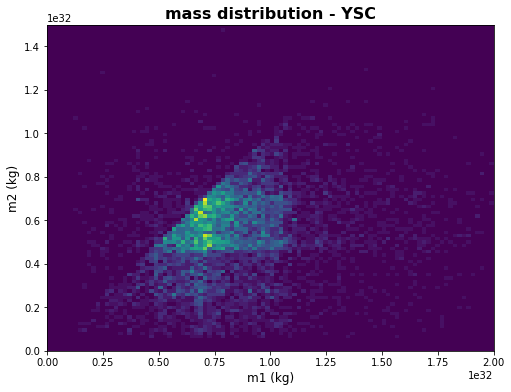

In [25]:
m1y, m2y = tot_masses(YSC_event, YSC_phys, YSC_flyby_event)
plt.figure(figsize=(8,6))
plt.title('mass distribution - YSC', fontsize = 16, fontweight = "bold")
plt.hist2d(m1y, m2y, bins=100, range=[[0,2e32],[0, 1.5e32]]) #, cmap=plt.cm.plasma,)
plt.xlabel('m1 (kg)', fontsize = 12)
plt.ylabel('m2 (kg)', fontsize = 12)
#plt.legend(loc='best')
plt.show()

In [26]:
names = ['m', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'simulation']
YSC_merge_nb = pd.read_csv( 'start_merge_YSC.dat' , sep=",", header=None, names=names)
YSC_merge = rescaling_physical(YSC_merge_nb)
YSC_merge

,m,x,y,z,vx,vy,vz,simulation
0,8.363261e+31,2.951333e+12,3.111635e+12,1.623625e+12,3.723731e+08,-1.104842e+09,-6.953398e+06,9926
1,7.021743e+31,3.072050e+12,3.170111e+12,1.623625e+12,-4.757222e+08,1.301968e+09,-6.953398e+06,9926
2,4.730599e+31,-9.777601e+12,-1.020656e+13,-5.280403e+12,4.780484e+07,2.071493e+07,2.261406e+07,9926
3,6.692858e+31,-6.544249e+11,-6.094452e+10,-6.842067e+11,-6.103931e+08,1.987142e+08,5.239239e+06,8856
4,5.621625e+31,-7.978638e+11,-1.104280e+11,-6.842067e+11,7.343934e+08,-2.327926e+08,5.239239e+06,8856
5,1.275206e+31,6.952028e+12,8.066760e+11,6.607290e+12,-3.388481e+07,-1.669809e+07,-5.059460e+07,8856
6,7.804409e+31,9.313039e+12,-3.488628e+12,2.014483e+13,-9.232922e+07,1.290077e+08,-2.921115e+07,8430
7,6.135837e+31,8.063636e+12,-3.634568e+12,2.014483e+13,9.336316e+07,-1.491256e+08,-2.921115e+07,8430
8,6.330961e+31,-1.929564e+13,7.823109e+12,-4.435723e+13,2.333198e+07,-1.450308e+07,6.432051e+07,8430
9,7.978214e+31,1.441719e+13,-1.124013e+13,-6.175520e+12,-2.718237e+08,3.066754e+08,1.296172e+06,5111


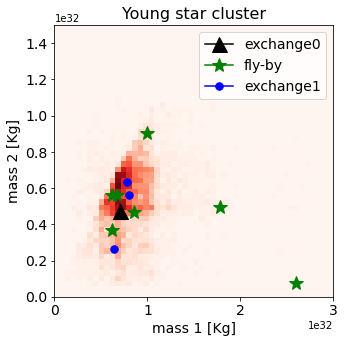

In [27]:
#9926 - ex0
m9926_1 = YSC_merge['m'][1]
m9926_2 = YSC_merge['m'][2]
#8856 - fb
m8856_1 = YSC_merge['m'][3]
m8856_2 = YSC_merge['m'][4]
#8430 - ex1
m8430_1 = YSC_merge['m'][6]
m8430_2 = YSC_merge['m'][8]
#5511 - ex1
m5511_1 = YSC_merge['m'][9]
m5511_2 = YSC_merge['m'][11]
#9768 - fb
m9768_1 = YSC_merge['m'][12]
m9768_2 = YSC_merge['m'][13]
#4789 - fb 
m4789_1 = YSC_merge['m'][15]
m4789_2 = YSC_merge['m'][16]
#1758 - fb
m1758_1 = YSC_merge['m'][18]
m1758_2 = YSC_merge['m'][19]
#7911 - ex1
m7911_1 = YSC_merge['m'][21]
m7911_2 = YSC_merge['m'][23]
#7412 - fb
m7412_1 = YSC_merge['m'][24]
m7412_2 = YSC_merge['m'][25]
#9208 - fb
m9208_1 = YSC_merge['m'][27]
m9208_2 = YSC_merge['m'][28]
#2416 - fb
m2416_1 = YSC_merge['m'][30]
m2416_2 = YSC_merge['m'][31]

fig = plt.figure(figsize=(5,5))
plt.title('Young star cluster', fontsize = 16)
plt.hist2d(m1y, m2y, bins=50, range=[[0,3e32],[0, 1.5e32]], cmap=plt.cm.Reds)
plt.plot(m9926_1, m9926_2, marker='^', markersize=15, label='exchange0', c='black')
plt.plot(m8856_1, m8856_2, marker='*', markersize=15, label='fly-by', c='green')
plt.plot(m8430_1, m8430_2, marker='.', markersize=15, label='exchange1', c='blue')
plt.plot(m5511_1, m5511_2, marker='.', markersize=15, c='blue') #label='ex1'
plt.plot(m9768_1, m9768_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m4789_1, m4789_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m1758_1, m1758_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m7911_1, m7911_2, marker='.', markersize=15, c='blue') #label='ex1'
plt.plot(m7412_1, m7412_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m9208_1, m9208_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m2416_1, m2416_2, marker='*', markersize=15, c='green') #label='fb'
plt.xlabel('mass 1 [Kg]', fontsize = 14)
plt.ylabel('mass 2 [Kg]', fontsize = 14)
plt.tick_params(axis = "x", labelsize = 14)
plt.tick_params(axis = "y", labelsize = 14)
plt.legend(loc='best', fontsize = 14)
plt.show()
fig.savefig("mass_2d_young.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)

## NSC

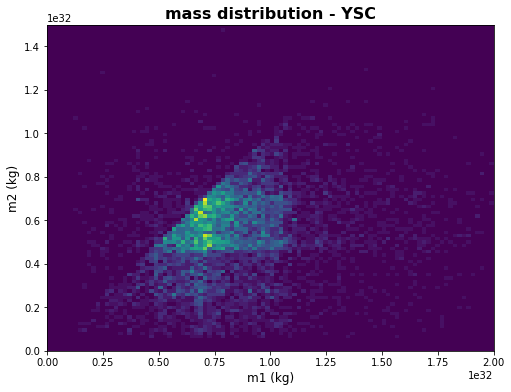

In [28]:
m1n, m2n = tot_masses(YSC_event, YSC_phys, YSC_flyby_event)
plt.figure(figsize=(8,6))
plt.title('mass distribution - YSC', fontsize = 16, fontweight = "bold")
plt.hist2d(m1n, m2n, bins=100, range=[[0,2e32],[0, 1.5e32]]) #, cmap=plt.cm.plasma,)
plt.xlabel('m1 (kg)', fontsize = 12)
plt.ylabel('m2 (kg)', fontsize = 12)
#plt.legend(loc='best')
plt.show()

In [29]:
names = ['m', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'simulation']
NSC_merge_nb = pd.read_csv( 'start_merge_NSC.dat' , sep=",", header=None, names=names)
NSC_merge = rescaling_physical(NSC_merge_nb)
NSC_merge

,m,x,y,z,vx,vy,vz,simulation
0,6.483813e+31,-6.087989e+11,-2.938493e+11,5.493227e+10,3.824410e+08,4.389736e+08,-1.742570e+07,1161
1,2.181282e+31,-6.501965e+11,-2.872902e+11,5.493227e+10,-5.228839e+08,-9.736829e+08,-1.742570e+07,1161
2,3.301243e+31,1.625327e+12,7.669610e+11,-1.441861e+11,-4.056409e+08,-2.188104e+08,4.573894e+07,1161
3,9.912763e+31,7.377236e+12,6.686717e+12,3.340447e+12,-4.357798e+07,2.013590e+07,-9.069085e+07,5480
4,7.077555e+31,6.903757e+12,6.760222e+12,3.340447e+12,-4.480795e+08,-5.023775e+08,-9.069085e+07,5480
...,...,...,...,...,...,...,...,...
61,6.512329e+31,-1.077937e+12,4.082009e+11,-2.431106e+11,-1.648682e+09,-1.057988e+08,1.779089e+07,1878
62,3.492731e+31,4.423849e+12,-1.627938e+12,1.024147e+12,-2.342581e+08,6.104844e+07,-7.494726e+07,1878
63,8.325858e+31,-1.044201e+12,4.822401e+11,2.350924e+11,-7.343126e+08,4.234786e+08,-6.301695e+07,3446
64,5.023168e+31,-1.082771e+12,4.547506e+11,2.350924e+11,1.886732e+09,-1.004620e+09,-6.301695e+07,3446


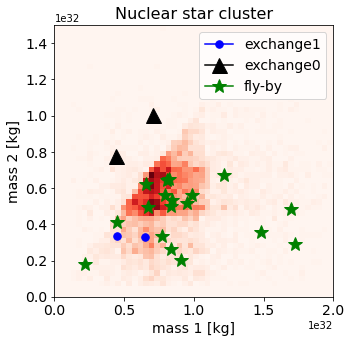

In [30]:
#TBS_1161 - ex1
m1161_1 = NSC_merge['m'][0]
m1161_2 = NSC_merge['m'][2]
#TBS_5480 - ex0
m5480_1 = NSC_merge['m'][4]
m5480_2 = NSC_merge['m'][5]
#TBS_3037 - fb
m3037_1 = NSC_merge['m'][6]
m3037_2 = NSC_merge['m'][7]
#TBS_5435 - fb
m5435_1 = NSC_merge['m'][9]
m5435_2 = NSC_merge['m'][10]
#TBS_2252 - fb
m2252_1 = NSC_merge['m'][12]
m2252_2 = NSC_merge['m'][13]
#TBS_7198 - ex0
m7198_1 = NSC_merge['m'][16]
m7198_2 = NSC_merge['m'][17]
#TBS_8764 - fb
m8764_1 = NSC_merge['m'][18]
m8764_2 = NSC_merge['m'][19]
#TBS_2623 - fb
m2623_1 = NSC_merge['m'][21]
m2623_2 = NSC_merge['m'][22]
#TBS_8692 - fb
m8692_1 = NSC_merge['m'][24]
m8692_2 = NSC_merge['m'][25]
#TBS_3077 - fb
m3077_1 = NSC_merge['m'][27]
m3077_2 = NSC_merge['m'][28]
#TBS_3212 - fb
m3212_1 = NSC_merge['m'][30]
m3212_2 = NSC_merge['m'][31]
#TBS_2048 - fb
m2048_1 = NSC_merge['m'][33]
m2048_2 = NSC_merge['m'][34]
#TBS_4297 - fb
m4297_1 = NSC_merge['m'][36]
m4297_2 = NSC_merge['m'][37]
#TBS_6820 - fb
m6820_1 = NSC_merge['m'][39]
m6820_2 = NSC_merge['m'][40]
#TBS_5727 - fb
m5727_1 = NSC_merge['m'][42]
m5727_2 = NSC_merge['m'][43]
#TBS_6389 - fb
m6389_1 = NSC_merge['m'][45]
m6389_2 = NSC_merge['m'][46]
#TBS_1449 - fb
m1449_1 = NSC_merge['m'][48]
m1449_2 = NSC_merge['m'][49]
#TBS_9427 - fb
m9427_1 = NSC_merge['m'][51]
m9427_2 = NSC_merge['m'][52]
#TBS_6064 - ex1
m6064_1 = NSC_merge['m'][54]
m6064_2 = NSC_merge['m'][56]
#TBS_9492 - fb
m9492_1 = NSC_merge['m'][57]
m9492_2 = NSC_merge['m'][58]
#TBS_1878 - fb
m1878_1 = NSC_merge['m'][60]
m1878_2 = NSC_merge['m'][61]
#TBS_3446 - fb
m3446_1 = NSC_merge['m'][63]
m3446_2 = NSC_merge['m'][64]

fig = plt.figure(figsize=(5,5))
plt.title('Nuclear star cluster', fontsize = 16)
plt.hist2d(m1n, m2n, bins=50, range=[[0,2e32],[0, 1.5e32]], cmap=plt.cm.Reds)
plt.plot(m1161_1, m1161_2, marker='.', markersize=15, label='exchange1', c='blue')
plt.plot(m5480_1, m5480_2, marker='^', markersize=15, label='exchange0', c='black')
plt.plot(m3037_1, m3037_2, marker='*', markersize=15, label='fly-by', c='green')
plt.plot(m5435_1, m5435_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m2252_1, m2252_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m7198_1, m7198_2, marker='^', markersize=15, c='black') #label='ex0'
plt.plot(m8764_1, m8764_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m2623_1, m2623_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m8692_1, m8692_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m3077_1, m3077_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m3212_1, m3212_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m2048_1, m2048_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m4297_1, m4297_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m6820_1, m6820_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m5727_1, m5727_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m6389_1, m6389_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m1449_1, m1449_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m9427_1, m9427_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m6064_1, m6064_2, marker='.', markersize=15, c='blue') #label='ex1' 
plt.plot(m9492_1, m9492_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m1878_1, m1878_2, marker='*', markersize=15, c='green') #label='fb'
plt.plot(m3446_1, m3446_2, marker='*', markersize=15, c='green') #label='fb'
plt.xlabel('mass 1 [kg]', fontsize = 14)
plt.ylabel('mass 2 [kg]', fontsize = 14)
plt.tick_params(axis = "x", labelsize = 14)
plt.tick_params(axis = "y", labelsize = 14)
plt.legend(loc='best', fontsize = 14)
plt.show()
fig.savefig("mass_2d_nuclear.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)